In [8]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import librosa
from scipy.special import softmax

In [9]:
# label mappings
label_map = {"Happiness":"hap",  "Excited":"exc", "Neutral":"neu", "Sadness":"sad", "Anger":"ang", "Surprise":"sur", "Fear":"fea", "Disgust":"dis", "Frustration":"fru", "Other": "oth"}

Define the emotion classes

In [10]:
emotions = ['hap', 'sad', 'ang', 'neu', 'exc', 'fru']
combine = False
name = 'hard'

In [11]:
#emotions = ['ang', 'exc', 'neu', 'sad']
#combine = True # combine hap to exc
#name = 'easy'

pick_prob alters the percentage of noise in the dataset

In [12]:
pick_prob = 0.6 # probability of picking noisy label if present. Use this to tweak noise %, 1, 0.8, 0.6, 0.4, set it to 1 for easy mode
lb2idx = {lb: idx for idx, lb in enumerate(emotions)}

Extract the noisy labels

In [13]:
def get_noisy_label(gt, ce1, ce2, ce3):
    choices = []

    #print("ce1", ce1)
    #print("ce2", ce2)
    #print("ce3", ce3)

    match = re.search(r'\s[\w+;\s?]+\s', ce1)

    if match is not None:
        choices.extend(match.group(0).split())
    
    match = re.search(r'\s[\w+;\s?]+\s', ce2)
    if match is not None:
        choices.extend(match.group(0).split())

    match = re.search(r'\s[\w+;\s?]+\s', ce3)
    if match is not None:
        choices.extend(match.group(0).split())  

    
    filtered_choices = []
    all_choices = []
    #print(choices)
    for choice in choices:
        choice = label_map[re.search('\w+', choice).group(0)]
        if combine and choice == 'hap':
            choice = 'exc'
        if choice in emotions:
            all_choices.append(choice)
            if choice != gt:
                filtered_choices.append(choice)

    soft_gt = np.zeros((len(emotions)))
    for choice in all_choices:
        soft_gt[lb2idx[choice]] += 1


    soft_gt = soft_gt/sum(soft_gt)


    if len(filtered_choices) == 0:
        return 'none', soft_gt

    noisy_label = random.choice(filtered_choices)
    return noisy_label, soft_gt


def get_comments(ce1, ce2, ce3):
    comments = []

    match = re.search(r'\(.+\)', ce1)
    if match is not None:
        comments.append(match.group(0))

    match = re.search(r'\(.+\)', ce2)
    if match is not None:
        comments.append(match.group(0))

    match = re.search(r'\(.+\)', ce3)
    if match is not None:
        comments.append(match.group(0))
    
    return comments   

In [14]:
# number of sessions
n_sess = 5

# to reproduce the same labels
SEED = 6
random.seed(SEED)

PROJ_DIR = os.path.expanduser("~") + "/IEMOCAP_full_release"


def create_dataset(session_id):
    df = pd.DataFrame(columns=['wavfile', 'noisy-label', 'ground-truth', 'soft-gt', 'comments', 'timestamps', 'audio-path'])
    # sample id
    idx = 0
    # paths
    SESSION_DIR = os.path.join(PROJ_DIR, "Session" + str(session_id))
    EVAL_DIR = os.path.join(SESSION_DIR, 'dialog', 'EmoEvaluation')
    AUDIO_DIR = os.path.join(SESSION_DIR, "sentences", "wav")

    durations = []

    # iterate over files present in each session
    for file in os.listdir(EVAL_DIR):
        if file.endswith('.txt'):
            with open(EVAL_DIR + '/' + file, 'rb') as fread: # iterate through lines in the file
                lines = fread.readlines()
                k = 1
                # iterate over utterances
                while k < len(lines):
                    if b'[' in lines[k]:
                        line = lines[k].decode('utf-8')
                        # get audio path
                        match = re.search(r'\bSes\w+\b', line)
                        if match is None:
                            k += 1
                            continue

                        # ground truth label
                        ground_truth =  re.search(r'(hap|neu|fru|exc|oth|dis|xxx|sad|ang|fea|sur)', line).group(0)
                        if ground_truth not in emotions: # we consider only the emotions listed
                            if combine and ground_truth == 'hap':
                                ground_truth = 'exc'
                            else:
                                k += 1
                                continue

                        df.loc[idx, 'wavfile'] = match.group(0)
                        df.loc[idx, 'audio-path'] = AUDIO_DIR + '/' + "_".join(match.group(0).split('_')[:-1]) + '/' + match.group(0) + '.wav'
                        df.loc[idx, 'ground-truth'] = ground_truth

                        
                        # randomly select a noisy label from CE labels
                        ce1 = lines[k+1].decode('utf-8') # Naive Annotator 1
                        ce2 = lines[k+2].decode('utf-8') # Naive Annotator 2
                        ce3 = lines[k+3].decode('utf-8') # Naive Annotator 3

                        noisy_label, soft_gt = get_noisy_label(ground_truth, ce1, ce2, ce3)
                        if noisy_label == "none":
                            df.loc[idx, 'noisy-label'] = ground_truth
                        else:
                            if random.random() <= pick_prob:
                                df.loc[idx, 'noisy-label'] = noisy_label
                            else:
                                df.loc[idx, 'noisy-label'] = ground_truth
                        df.loc[idx, 'soft-gt'] = soft_gt

                        # get annotator comments
                        comments = get_comments(ce1, ce2, ce3)
                        df.loc[idx, 'comments'] = ".".join(comments)

                        # get timestamps
                        match = re.search(r'\[[\d\-\.\s]+\]', line)
                        df.loc[idx, 'timestamps'] = match.group(0)

                        idx += 1
                    k += 1
    return df

# create train set
train_df = pd.DataFrame(columns=['wavfile', 'noisy-label', 'ground-truth', 'comments', 'timestamps', 'audio-path'])
for i in trange(1, 5):
    train_df = pd.concat([train_df, create_dataset(i)])


# create test set
test_df = create_dataset(session_id=5)
    

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


In [15]:
print(train_df[:5])

               wavfile noisy-label ground-truth comments           timestamps  \
0  Ses01M_impro02_F000         fru          neu            [8.0737 - 11.4700]   
1  Ses01M_impro02_F003         fru          fru           [35.4000 - 38.6000]   
2  Ses01M_impro02_F004         ang          fru           [40.1000 - 42.3725]   
3  Ses01M_impro02_F005         fru          fru           [42.4950 - 45.8200]   
4  Ses01M_impro02_F006         fru          fru           [53.4950 - 54.9950]   

                                          audio-path  \
0  /home/kriti/IEMOCAP_full_release/Session1/sent...   
1  /home/kriti/IEMOCAP_full_release/Session1/sent...   
2  /home/kriti/IEMOCAP_full_release/Session1/sent...   
3  /home/kriti/IEMOCAP_full_release/Session1/sent...   
4  /home/kriti/IEMOCAP_full_release/Session1/sent...   

                                             soft-gt  
0  [0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.333...  
1                     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  
2  [0.0, 0.

In [16]:
print(test_df[:5])

               wavfile noisy-label ground-truth  \
0  Ses05M_impro07_F000         neu          exc   
1  Ses05M_impro07_F001         hap          exc   
2  Ses05M_impro07_F003         hap          exc   
3  Ses05M_impro07_F004         exc          hap   
4  Ses05M_impro07_F005         exc          hap   

                                             soft-gt comments  \
0                   [0.25, 0.0, 0.0, 0.25, 0.5, 0.0]            
1  [0.3333333333333333, 0.0, 0.0, 0.0, 0.66666666...            
2  [0.3333333333333333, 0.0, 0.0, 0.0, 0.66666666...            
3  [0.6666666666666666, 0.0, 0.0, 0.0, 0.33333333...            
4  [0.6666666666666666, 0.0, 0.0, 0.0, 0.33333333...            

            timestamps                                         audio-path  
0    [5.4800 - 6.7000]  /home/kriti/IEMOCAP_full_release/Session5/sent...  
1    [8.3300 - 9.6900]  /home/kriti/IEMOCAP_full_release/Session5/sent...  
2  [11.3500 - 13.6000]  /home/kriti/IEMOCAP_full_release/Session5/sent... 

In [17]:
#print("With xxx labeled samples")
print(classification_report(train_df['ground-truth'], train_df['noisy-label']))

report = classification_report(train_df['ground-truth'], train_df['noisy-label'], output_dict=True)
noise_percentage = round((1 - report['accuracy'])*100, 2)
print(noise_percentage)

#print("Without xxx labeled samples")
#subset_df = train_df[train_df['ground-truth']!='xxx']
#print(classification_report(subset_df['ground-truth'], subset_df['noisy-label']))

train_df.to_csv(name + '-' + str(noise_percentage) + '-train.csv', index=False)
test_df.to_csv(name + '-' + str(noise_percentage) + '-test.csv', index=False)

              precision    recall  f1-score   support

         ang       0.61      0.63      0.62       933
         exc       0.58      0.60      0.59       742
         fru       0.55      0.60      0.57      1468
         hap       0.43      0.47      0.45       452
         neu       0.63      0.56      0.60      1324
         sad       0.77      0.68      0.72       839

    accuracy                           0.60      5758
   macro avg       0.59      0.59      0.59      5758
weighted avg       0.60      0.60      0.60      5758

40.19


In [18]:
durations = []
means = []
sample_rate = 16000
for i in trange(len(train_df)):
    audio_path = train_df.iloc[i]['audio-path']
    (audio, fs) = librosa.core.load(audio_path, sr=sample_rate, mono=True)
    durations.append(librosa.get_duration(y=audio, sr=sample_rate))
    means.append(np.mean(abs(audio)))

100%|██████████| 5758/5758 [00:03<00:00, 1590.27it/s]


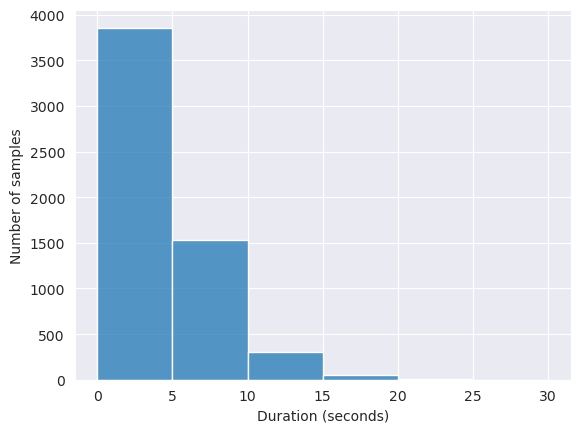

In [19]:
import seaborn as sns
import pandas as pd

sns.set_style('darkgrid')
bin_edges = list(range(0, int(max(durations)) + 5, 5))
sns.histplot(x=durations, bins=bin_edges) # density=False would make counts
plt.ylabel('Number of samples')
plt.xlabel('Duration (seconds)')
plt.savefig('/home/kriti/ambivalent/images/durations.png')

In [20]:
print(len(train_df))
train_df.groupby(['ground-truth'])['wavfile'].count()

5758


ground-truth
ang     933
exc     742
fru    1468
hap     452
neu    1324
sad     839
Name: wavfile, dtype: int64

In [21]:
print(len(test_df))
test_df.groupby(['ground-truth'])['wavfile'].count()

1622


ground-truth
ang    170
exc    299
fru    381
hap    143
neu    384
sad    245
Name: wavfile, dtype: int64

In [ ]:
full_df = pd.concat([train_df,test_df])
full_df

In [ ]:
print(len(train_df))
print(len(test_df))

5758
1622


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

df = pd.read_csv('/home/kriti/ambivalent/src/hard-26.48-train.csv')

print(classification_report(df['ground-truth'], df['noisy-label']))

              precision    recall  f1-score   support

         ang       0.75      0.75      0.75       933
         exc       0.71      0.74      0.72       742
         fru       0.69      0.74      0.72      1468
         hap       0.61      0.64      0.62       452
         neu       0.77      0.72      0.74      1324
         sad       0.86      0.79      0.82       839

    accuracy                           0.74      5758
   macro avg       0.73      0.73      0.73      5758
weighted avg       0.74      0.74      0.74      5758

